<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
    <h1>Team GAIASAVERS</h1>
    <h3>Alban Petit, Wafa Bouzouita,Timothée Babinet, Maxime Chor, Eric Wang, Sebastien Warichet</h3>
    <h2>Plankton classification challenge</h2>

<br>This code was tested with <br>
Python 3.7 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
     <br>
       
According to [NRMA15], a link has been found between the quality of water and the presence of plankton in said water. As water quality increases, the abundance and diversity of plankton does as well. The aim of our project is to build a plankton classifier to assess water quality.

We use for this problem the Bering Sea dataset, an in situ plankton dataset published in May 2019 by Kaichang Cheng [Che19]. This datset contains 7 classes with an even spread.

        
References and credits: 
- [NRMA15] A. Nair, J.K. Reshma, A. Mathew, and A. Ashok. Effect of water quality on phytoplankton abundance in selected ponds of nedumangad block panchayat, kerala. Emer Life Sci Res, 2015.
- [Che19] K. Cheng. Bering sea dataset. https://doi.org/10.6084/m9.figshare.8146283.v3, 2019.
 <br>
</div>

<img src="images/sample.png" alt="Drawing"/>
To see more images for each class, see the "images" folder.

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [5]:
#data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_dir = 'public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*

plankton_feat.name    plankton_test.data       plankton_valid.data
plankton_label.name   plankton_train.data
plankton_public.info  plankton_train.solution


<h3>Two "feature representation"</h3>

<p>
1.
All of the images are in various shades of gray. As such, we can represent every image by a vector of 90000 (300x300) features where each feature is a float value between 0 and 255 representing the brightness of a pixel (0 being a black pixel and 255 a white one). It is also possible to reduce the size of the images to reduce the number of features as seen in figure 3 where we reduced the size to 100x100 pixels.
</p>

<tr>
    <td> <img src="images/gray.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="images/binarized.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


<p>
2. At first we will have four types of "features". Two "features" are applied on the binarized images.
    <ul>
        <li>The first is a sum of black pixels, per line and per column.
This gives us 2 vectors of size 100. These "features" are representative among others of the shape of the plankton.
For round seeders the ratio between rows and columns near the center of the image should be close.
For longer plankton the ratio will be either low or high, depending on plankton position.
        </li>
        <li>The second is the average of the pixels.
            This gives us information on the size of the plankton.
        </li>
        <li>The third feature is the variance and is applied to non-binarized images.</li>
        <li>The last feature is the length of the contour of the plankton. It is obtained by applying a sobel filter on the image. This filter will put black pixels on the contours and white ones everywhere else. We can then just compute the amount of black pixels.
    </ul>
</p>

For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [6]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


This shows the distribution of labels in the training set

In [7]:
#data['target'].value_counts()

The first rows of the dataset.

In [8]:
data.head()

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length,target
0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.83871,0.83871,0.827957,0.817204,0.795699,0.774194,0.744560,0.062088,9.82,other
1,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,0.852347,0.021939,0.64,other
2,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.82000,0.90000,1.000000,1.000000,1.000000,1.000000,0.478031,0.130620,6.68,limacina
3,1.0,1.0,0.99,0.96,0.94,0.94,0.92,0.92,0.92,0.93,...,0.96000,0.99000,1.000000,1.000000,1.000000,1.000000,0.799294,0.037921,6.86,chaetognatha
4,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,0.99000,0.990000,0.990000,1.000000,1.000000,0.713423,0.065195,11.56,medusae


Some statistics about the features.

In [9]:
Y_train

NameError: name 'Y_train' is not defined

In [10]:
#data[['sum_axis_0_50','sum_axis_1_50','mean','variance', 'outline_length']].hist(figsize=(10, 10), bins=50, layout=(3, 2));

In [11]:
"""from sklearn import preprocessing
data_target = data.copy()
le = preprocessing.LabelEncoder()
data_target.target = le.fit_transform(data_target.target.values)
fig = plt.figure(figsize=(15,8))
sns.heatmap(data_target[['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length','target']].corr(), annot = True)
plt.title('Correlation_matrix')
plt.show()"""

"from sklearn import preprocessing\ndata_target = data.copy()\nle = preprocessing.LabelEncoder()\ndata_target.target = le.fit_transform(data_target.target.values)\nfig = plt.figure(figsize=(15,8))\nsns.heatmap(data_target[['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length','target']].corr(), annot = True)\nplt.title('Correlation_matrix')\nplt.show()"

In [12]:
#sns.pairplot(data,hue='target',vars=['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length'])
#plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
</div>

In [13]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/ramdane/Bureau/PLANKTON/starting_kit/public_data/plankton_public.info
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [14]:
from data_io import write
from model import model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

#M = model(  ExtraTreesClassifier (n_estimators=86))
#CV score (95 perc. CI): 0.78 (+/- 0.01)
#{'random_state': 1, 'n_estimators': 116, 'min_samples_split': 2}


M = model(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)) 
#CV score (95 perc. CI): 0.78 (+/- 0.01)
#{'random_state': 1, 'n_estimators': 116, 'min_samples_split': 2}


trained_model_name = model_dir + data_name

# Because we test a lot of model, to not lose time we can reload the last model to make tests faster
# Uncomment the next line to re-load an already trained model
#M = model()
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [43]:
X_train = D.data['X_train']
Y_train = D.data['Y_train'].ravel()

#from sklearn.model_selection import train_test_split
seed = 1

#X_train, X_valid, Y_train, Y_valid = train_test_split( X_donnees, Y_donnees, test_size=0.33, random_state=seed, stratify=Y_donnees)


if not(M.is_trained):
    M.fit(X_train, Y_train)
    print('training')

FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]
training


In [44]:
Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [45]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

<div style="background:#FFFFAA">
The chosen metric is the balanced accuracy. It computes the proportion of elements correctly predicted for each class. It then returns the mean of these values. The advantage of this metric is that every class is given an equal weight. <br> In our case, since all the classes are perfectly balanced, it is equivalent to simply computing the accuracy score but it the case the test set is changed and is no longer balanced, the balanced accuracy will still work properly while the accuracy score will not.
</div>

In [46]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: balanced_accuracy_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [47]:
print('Training train score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training train score for the balanced_accuracy_score metric = 0.9998
Ideal score for the balanced_accuracy_score metric = 1.0000


You can add here other scores and result visualization.

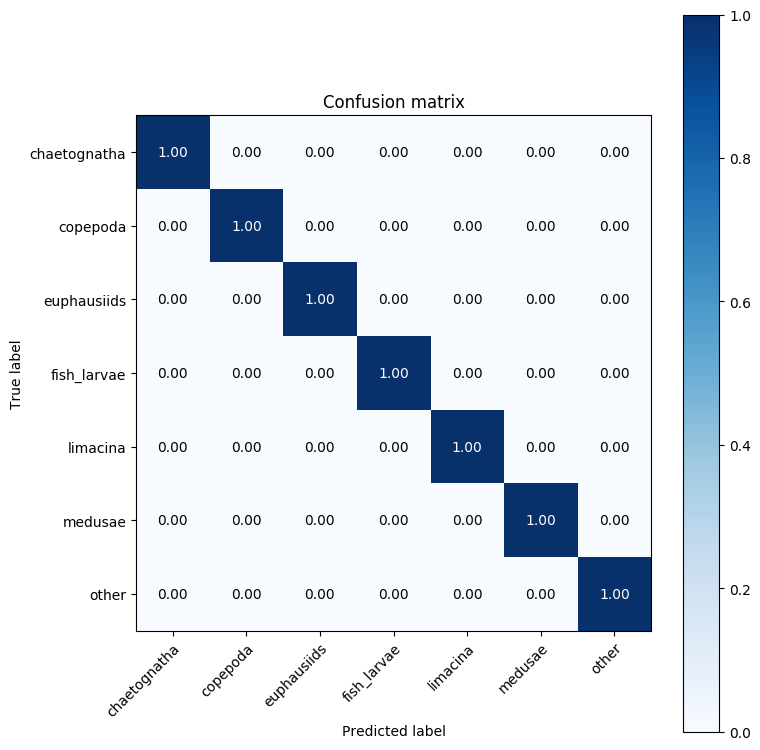

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]
cm = confusion_matrix(Y_train, Y_hat_train)
cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix",xlabel="Predicted label",ylabel="True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [88]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]

CV score (95 perc. CI): 0.78 (+/- 0.01)


In [50]:
print( (scores.mean())) # extra printing to see the details

0.7776573736195445


In [51]:
#??scoring_function

# Finding the best model

## We define a functon many models and compare the cross-validation and training performance








In [89]:
def finBest(model_name, model_list):
    
    """
    Runs different models with random parameters.
    For each model we calculate the cross-valdiation and training performance
    
    Parameters
    ----------
    model_name: model's liste
    model_list: list of random values for models
    
    
    Returns
    ------
    C1: model name
    C2: cross-validation score
    C3: training performance
    
    """

    #----------------
    from libscores import get_metric
    #print('Using scoring metric:', metric_name)
    #----------------
    
    X_donnees = D.data['X_train']
    Y_donnees = D.data['Y_train']

    c1=[]
    c2=[]
    c3=[]
    
    
    for i in np.arange(len(model_list)) :

        
        M = model(classifier=model_list[i])
        trained_model_name = model_dir + data_name

        if not(M.is_trained):
            M.fit(X_train, Y_train)        
        
        M.save(trained_model_name)                 
        result_name = result_dir + data_name
        from data_io import write
        Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
        Y_hat_valid = M.predict(D.data['X_valid'])
        #write(result_name + '_test.predict', Y_hat_test)
        !ls $result_name*
        
        metric_name, scoring_function = get_metric()
        
        scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
        
        #print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
        
        #res.append([model_name[i], scores.mean(), '   metric = %5.4f' % scoring_function(Y_train, Y_hat_train)])
        #print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
        c1.append(model_name[i])
        c2.append(scores.mean())
        print(">>>>>>", scores)
        c3.append(scoring_function(Y_train, Y_hat_train))
        
        #print('Training train score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
        #print('Training valid score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_valid, Y_hat_valid))
        #print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

    return c1,c2,c3

In [90]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier


model_name = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "ExtraTreesClassifier"]
model_list = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=10),
    #RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    ExtraTreesClassifier()
]

In [91]:
from sklearn.model_selection import train_test_split

from data_io import write
from model import model

from data_io import write

from libscores import get_metric

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [92]:
"""
model_name = ["rf1", "ExtraTreesClassifier", "Random Forest"]
model_list = [
    RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0),
    ExtraTreesClassifier(n_estimators=2),
    RandomForestClassifier(n_estimators=2, max_depth=None, min_samples_split=2, random_state=1),
]"""

res1, res2, res3 = finBest(model_name, model_list)

FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]
PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
>>>>>> [0.69575494 0.70545434 0.71452742 0.72274168 0.70557054]
FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]
PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
P

In [93]:
#affiche_models(res.append(res1,res2,res3)) # comment we use panda to display a proper table
frame = pd.DataFrame(
    {
                    "Model " : res1,
                    "Cross-Validation ": res2,
                    "train ": res3,
    }
)

frame

,Model,Cross-Validation,train
0,Nearest Neighbors,0.708810,0.999814
1,Decision Tree,0.613738,0.726749
2,Random Forest,0.779545,0.999814
3,Neural Net,0.526545,0.610491
4,AdaBoost,0.404023,0.426990
5,Naive Bayes,0.431674,0.437500
6,QDA,0.460282,0.606585
7,ExtraTreesClassifier,0.782045,0.999814


module

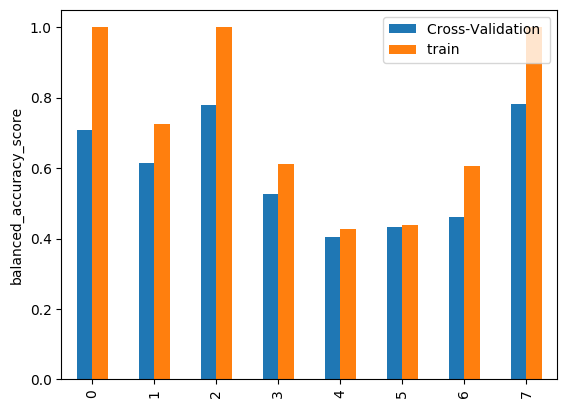

In [95]:
from sklearn.metrics import balanced_accuracy_score as sklearn_metric

frame[['Cross-Validation ', 'train ']].plot.bar()
#plt.ylim(0.5, 1)
plt.ylabel(sklearn_metric.__name__)

type(plt)

## sklearn.ensemble.RandomForestClassifier:
The two best models are ExtraTreesCLassieer and RandomForest because they have th best CV score far away the other models, they look over-fitted because of the differnece between the train and the valid data. 

### Sometimes I have the same metric between train and valid for the two models, maybe it is because of the seed ?? I can't conclude right now, I am going to ask the teacher next Friday.

### ==> IS THERE A PROBLEME ???? But after many tests the two best model are still ExtraTreesCLassieer and RandomForest

### In conclusion of these probleme is that we find that the data are the problem, what ever we do we always overfit. To fix this this probleme, we look at the CV and the valid column to select the best model. So we can say that the best model is the Random forest. It is a real problem because we can't find the best parameters, even when we use RandomizedSearchCV below. I have tryed to fix probleme with using one global seed. 

# We now use scikit functions to find the best parameters for the best model

## sklearn.ensemble.RandomForestClassifier:

Advantages of RandomForestClassifier:
 - the algorithm is not biased beceause it looks at the entirety of the data
 - the algorithm is stable because it not affect it when new data is intoduced, especially when the new data affects one tree in particular
 - works well with data that isn't scaled

Disadvantages of using RandomForestClassifier:
- Complexity, but in our case we do not use big data (>100k)
- take much more more time beceause of the complexity

The parameters:
- n_estimators: represents the number of trees in the forest. Usually higher number of trees improve the conditions to learn on the data. However, adding a lot of trees can slow down the training process considerably. Therefore we do a parameter search to find the sweet spot, with RandomizedSearchCV for instance.
- max_depth: represents the depth of each tree in the forest. The deeper the  tree, the more "splitted" it becomes and the more information about the data it captures. max_depth equals None means nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split: represents the minimum number of samples required to split an internal node. This can vary from one sample per node to all the samples for each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples for each node.
- min_samples_leaf: the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however it describes the minimum number of samples at the leaves, the base of the tree.


Over-fitting:
- over-fitting occurs when the model has good performance (scores) on the training data but not on the valid data

Under-fitting:
- iunder-fitting occurs when the model does not have good performances (scores) on the training and valid data


If we run tests with ExtraTreesCLassifier, the CV score is the same as Random Forest. We read that the algorithms are very similar and this is also maybe because extreme trees seem to keep a higher performance in presence of noisy features (like the seventh class for example). We can also see that they have the same parameters (the ones shown above). I left the tests down below.

In [296]:
X_train.shape

(7203, 203)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

def best_param_MODEL(logistic, distributions): 
    """
    This function finds the best parameters for the RandomizedSearchCV model and returns the best parameters
    
    Parameters
    ----------
    logistic: model's name
    distributions: dictionary of the different parameters of the model that will be tested


    Returns
    ------
    search: the best parameters

    """
    metric_name, scoring_function = get_metric()

    clf = RandomizedSearchCV(logistic, distributions, random_state=0, scoring=make_scorer(scoring_function) )
    search = clf.fit(X_train, Y_train)
    search.best_params_
    return search

In [65]:
#RandomForestClassifier
logistic = RandomForestClassifier()
# first tests
#distributions = dict( n_estimators=np.arange(0,200) , min_samples_split=[0,1,2],random_state=np.arange(0,20,1), min_samples_leaf=np.arange(0,20,1) )
#{'random_state': 19, 'n_estimators': 196, 'min_samples_split': 2, 'min_samples_leaf': 7} 
# bad results

distributions = dict( n_estimators=np.arange(10,200) , min_samples_split=[2],random_state=[0,1,2] )
# best results when we don't use min_samples_leaf et set it as default parameters




"""
#KNeighborsClassifier
logistic = KNeighborsClassifier(7)
distributions = dict(n_neighbors=np.arange(0,10), algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])

#ExtraTreesClassifier
logistic = ExtraTreesClassifier()
distributions = dict(n_estimators=np.arange(0,100))"""

"\n#KNeighborsClassifier\nlogistic = KNeighborsClassifier(7)\ndistributions = dict(n_neighbors=np.arange(0,10), algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])\n\n#ExtraTreesClassifier\nlogistic = ExtraTreesClassifier()\ndistributions = dict(n_estimators=np.arange(0,100))"

In [66]:
search = best_param_MODEL(logistic, distributions)

search.best_params_

{'random_state': 2, 'n_estimators': 125, 'min_samples_split': 2}

In [67]:
search.cv_results_

{'mean_fit_time': array([2.69830647, 3.53978047, 1.90275998, 5.92501073, 0.80628958,
        6.5052474 , 5.17329149, 5.67289438, 4.6055171 , 4.05586224]),
 'std_fit_time': array([0.01807194, 0.06569419, 0.01507836, 0.08538824, 0.01297481,
        0.13886906, 0.06010731, 0.11917282, 0.07206305, 0.12338339]),
 'mean_score_time': array([0.02919884, 0.0364789 , 0.02085547, 0.06300497, 0.00997977,
        0.06793308, 0.05612216, 0.05976524, 0.04796371, 0.04178696]),
 'std_score_time': array([0.00202381, 0.00109536, 0.00019857, 0.00412225, 0.00017412,
        0.00250487, 0.00486065, 0.00257712, 0.00275986, 0.00144386]),
 'param_random_state': masked_array(data=[1, 0, 0, 0, 1, 0, 0, 0, 2, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[75, 97, 54, 166, 22, 182, 138, 153, 125, 112],
              mask=[False, False, False, False, False

# We tyred this, but it stills overfit ...

In [96]:
def doBestModel(Model_final):
    """
    Runs the final model with best parameters 
    We then calculate the cross-validation and training performance    
    
    ----------
    Model_final: the best model with the best parameters


    Void
    ------
    show the CV score

    """

    M = Model_final
    if not(M.is_trained):
        M.fit(X_train, Y_train)
        
    trained_model_name = model_dir + data_name

    #Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
    Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
    Y_hat_valid = M.predict(D.data['X_valid'])
    Y_hat_test = M.predict(D.data['X_test'])


    M.save(trained_model_name)                 
    result_name = result_dir + data_name
    from data_io import write
    write(result_name + '_train.predict', Y_hat_train)
    write(result_name + '_valid.predict', Y_hat_valid)
    write(result_name + '_test.predict', Y_hat_test)
    !ls $result_name*

    metric_name, scoring_function = get_metric()
    scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    print('Training train score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
    print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
    

In [97]:
Model_final = model(  RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0) )
#Model_final = model(  RandomForestClassifier(n_estimators=182, max_depth=None, min_samples_split=2, random_state=1) ) #also good parameters
doBestModel(Model_final)

FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]
PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]
PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
Training train score for the balanced_accuracy_score metric = 0.9998

CV score (95 perc. CI): 0.78 (+/- 0.01)


In [184]:
logistic = ExtraTreesClassifier()
distributions = dict( n_estimators=np.arange(0,200))
#search = best_param_MODEL(logistic, distributions)
#search.best_params_

In [ ]:
Model_final = model(ExtraTreesClassifier (n_estimators=152)) 
#doBestModel(Model_final) #CV score (95 perc. CI): 0.78 (+/- 0.01)

In [ ]:
#Model_final = model(  RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1)) 
#doBestModel(Model_final)

## Stack and Voting

The main difference between stacking and voting and voting is that stacking looks at the highest probability for a given data calculated by all the models. While voting looks at the highest number of data allocation of all models, for example if three model of 4 choose the feature 1, then it will be the feature 1.

We are going to work here on the stacking. I have choosen the three best models, and best parameters that I tested (with cv ). I also tryed to correct the over-fitting of my data.

In [104]:
model_list = [
    ('rf', ExtraTreesClassifier()),
    #('knb',     KNeighborsClassifier(1),
    ('rfc', RandomForestClassifier(n_estimators=116, max_depth=None, min_samples_split=2, random_state=1)),
    ('rfc1',      MLPClassifier(alpha=1, max_iter=1000)),
    ('rfc2',      GaussianNB()),
    ('rfc3',          QuadraticDiscriminantAnalysis()),

]

In [105]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [106]:
clf = StackingClassifier(estimators=model_list, final_estimator=LogisticRegression())
doBestModel(model(clf))

FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8601, 203]
FIT: dim(y)= [8601, 1]


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PREDICT: dim(X)= [2151, 203]
PREDICT: dim(y)= [2151, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
FIT: dim(X)= [8602, 203]
FIT: dim(y)= [8602, 1]
PREDICT: dim(X)= [2150, 203]
PREDICT: dim(y)= [2150, 1]
Training train score for the balanced_accuracy_score metric = 0.9998

CV score (95 perc. CI): 0.81 (+/- 0.01)


/home/ramdane/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Looks good, I know how I can use stacking and woting, but I want to debug the metric score on the train data before I continue.

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)